# Template - Strategy - Backtesting 

### Import Library

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy
# from backtesting._plotting import set_bokeh_output
# set_bokeh_output(notebook=False)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

/home/zuongthao/PycharmProjects/algo-stock/venv/lib/python3.11/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

### Load Price Data

In [2]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [3]:
data = dataset.copy()

In [4]:
data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
# data = data[data.index > '2024-11-01 00:00:00']

In [5]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2024-09-30 14:15:00,1353.1,1353.9,1351.5,1353.1,6265
2024-09-30 14:20:00,1353.0,1354.7,1352.6,1354.6,4426
2024-09-30 14:25:00,1354.6,1356.3,1354.1,1355.9,7920


In [6]:
def prepare_data(htd):
    htd['max_5'] = htd['High'].rolling(5).max()
    htd['min_5'] = htd['Low'].rolling(5).min()
    return htd

In [7]:
prepared_data = prepare_data(data)
prepared_data.dropna(inplace=True)

In [8]:
class MainStrategy(Strategy):
    max_sl = 3.5
    trailing_sl = 5.5
    tp_step = 20
    def init(self):
        self._broker._cash = 1500
        super().init()

    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position.is_long or self.position.is_short:
                self.position.close()
                return
                
        if current_time.hour == 14 and current_time.minute >= 30:
            return

        close_price = self.data.Close[-1]
        if self.position.is_long:
            max_5 = self.data.max_5[-1]
            if close_price < max_5 - self.trailing_sl:
                self.position.close()
        elif self.position.is_short:
            min_5 = self.data.min_5[-1]
            if close_price > min_5 + self.trailing_sl:
                self.position.close()

        if self.position:
            return  
        
        if current_time.hour == 9 and current_time.minute == 0:
            sell_price = close_price
            max_5 = self.data.max_5[-1]
            tmp_risk = max_5 - sell_price
            risk = min(tmp_risk, self.max_sl)
            sl = sell_price + risk
            tp = sell_price - self.tp_step
            self.sell(size=1, sl=sl, tp=tp)

In [9]:
bt = Backtest(prepared_data, MainStrategy, commission=.0003, exclusive_orders=True)
stats = bt.run()

In [10]:
stats

Start                     2020-11-02 09:20:00
End                       2024-09-30 14:45:00
Duration                   1428 days 05:25:00
Exposure Time [%]                   20.287874
Equity Final [$]                   1559.71204
Equity Peak [$]                    1683.81561
Return [%]                           3.980803
Buy & Hold Return [%]               51.079938
Return (Ann.) [%]                    1.012996
Volatility (Ann.) [%]                4.438652
Sharpe Ratio                         0.228222
Sortino Ratio                        0.555413
Calmar Ratio                         0.133494
Max. Drawdown [%]                   -7.588353
Avg. Drawdown [%]                   -0.607158
Max. Drawdown Duration      560 days 21:35:00
Avg. Drawdown Duration       19 days 08:52:00
# Trades                                  763
Win Rate [%]                        25.557012
Best Trade [%]                       2.148798
Worst Trade [%]                      -0.46368
Avg. Trade [%]                    

In [11]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
0,-1,48,65,908.32742,909.4,-1.07258,-0.001181,2020-11-03 09:05:00,2020-11-03 10:30:00,None,0 days 01:25:00
1,-1,99,112,908.62733,909.9,-1.27267,-0.001401,2020-11-04 09:05:00,2020-11-04 10:10:00,None,0 days 01:05:00
2,-1,150,160,913.52586,915.2,-1.67414,-0.001833,2020-11-05 09:05:00,2020-11-05 09:55:00,None,0 days 00:50:00
3,-1,201,249,911.62643,910.5,1.12643,0.001236,2020-11-06 09:05:00,2020-11-06 14:30:00,None,0 days 05:25:00
4,-1,252,253,914.52556,914.6,-0.07444,-0.000081,2020-11-09 09:05:00,2020-11-09 09:10:00,None,0 days 00:05:00
...,...,...,...,...,...,...,...,...,...,...,...
758,-1,49490,49495,1324.80244,1327.4,-2.59756,-0.001961,2024-09-24 09:05:00,2024-09-24 09:30:00,None,0 days 00:25:00
759,-1,49541,49542,1337.19872,1338.5,-1.30128,-0.000973,2024-09-25 09:05:00,2024-09-25 09:10:00,None,0 days 00:05:00
760,-1,49592,49592,1345.89611,1346.5,-0.60389,-0.000449,2024-09-26 09:05:00,2024-09-26 09:05:00,None,0 days 00:00:00
761,-1,49643,49645,1357.49263,1360.9,-3.40737,-0.002510,2024-09-27 09:05:00,2024-09-27 09:15:00,None,0 days 00:10:00


In [12]:
# bt.plot()

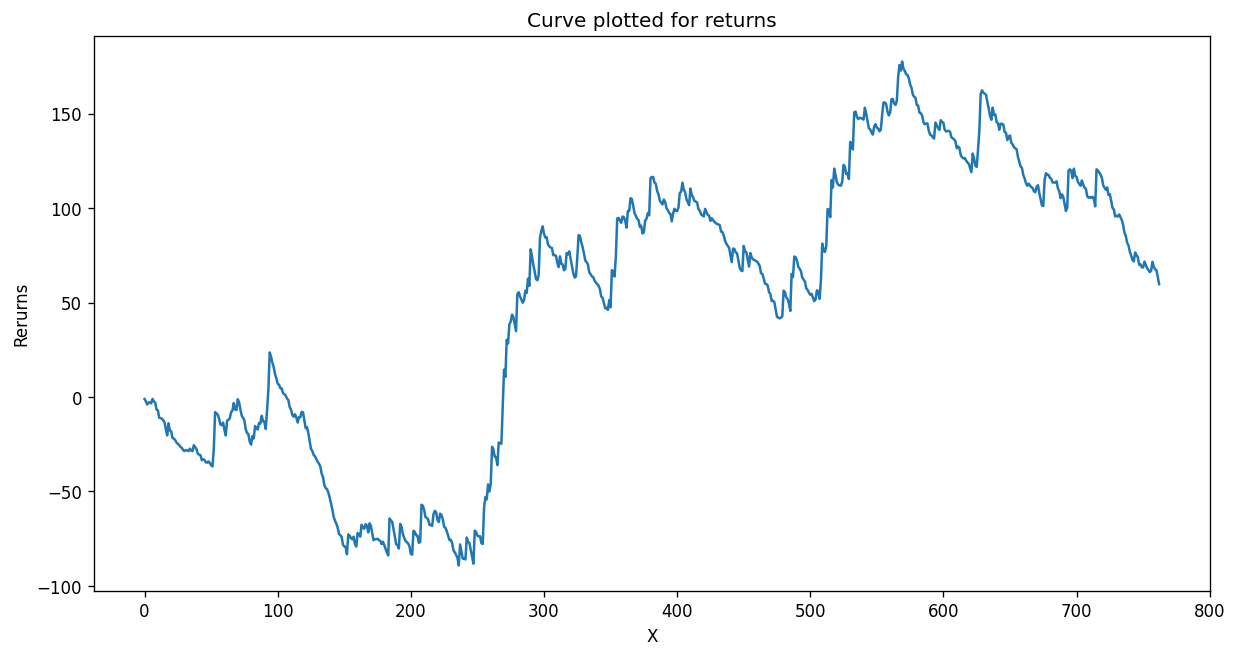

In [13]:
copy_trades = stats['_trades'].copy()
copy_trades['cum_sum'] = copy_trades['PnL'].cumsum()
X = np.array(range(0, len(copy_trades['cum_sum'])))
Y = copy_trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()

In [14]:
copy_trades['PnL'].max()

19.823159999999916

In [15]:
copy_trades['PnL'].min()

-4.745930000000044